In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from utils import *
from models.vision import *
import warnings
warnings.filterwarnings("ignore")

e:\Users\abuba\anaconda3\envs\dl\envs\dl_cuda\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [2]:
data_dir = './data/full/'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [3]:
# Define normalization statistics for the dataset
stats = ((0.5079, 0.5079, 0.5079), (0.2563, 0.2563, 0.2563))

# Define the data augmentation and transformation pipeline for the training set
train_tfms = tt.Compose([
    tt.RandomCrop(48, padding=4, padding_mode='reflect'),
    tt.RandomRotation(15),
    tt.RandomResizedCrop(112, scale=(0.8, 1.0)),
    tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

# Define the data transformation pipeline for the validation set
valid_tfms = tt.Compose([
    tt.Resize((112, 112)),
    tt.ToTensor(),
    tt.Normalize(*stats)
])


# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [4]:
batch_size = 32
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

In [5]:
device = get_default_device()

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [6]:

@torch.no_grad()
def evaluate(model, val_loader):
    obj = ImageClassificationBase()
    model.eval()
    outputs = [obj.validation_step(batch, model) for batch in val_loader]
    return obj.validation_epoch_end(outputs, model)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            images, labels = batch 
            out = model(images)                  # Generate predictions
            loss = F.cross_entropy(out, labels) # Calculate loss
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        obj = ImageClassificationBase()
        obj.epoch_end(epoch, result)
        history.append(result)
    return history

In [7]:
model = ResNetWithAttention().to(device)

for param in model.features.parameters():
    param.requires_grad = True

for param in model.fc.parameters():
    param.requires_grad = True

for param in model.attention.parameters():
    param.requires_grad = True
    
model

ResNetWithAttention(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [12]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.1154857873916626, 'val_acc': 0.5875553488731384}]

In [13]:
epochs = 15
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [14]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00015, train_loss: 1.0607, val_loss: 1.0539, val_acc: 0.6080
Epoch [1], last_lr: 0.00044, train_loss: 1.1394, val_loss: 1.2409, val_acc: 0.5608


KeyboardInterrupt: 

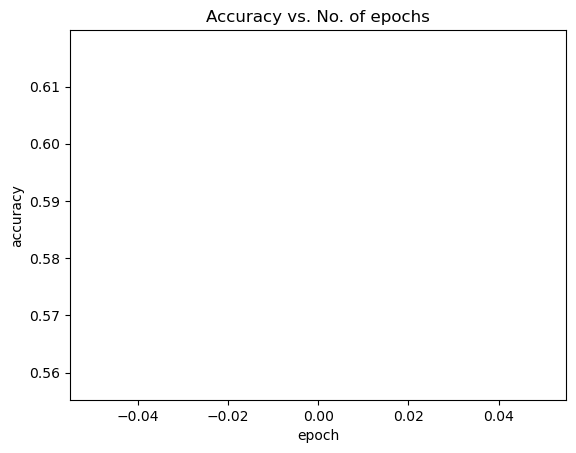

In [15]:
plot_accuracies(history)

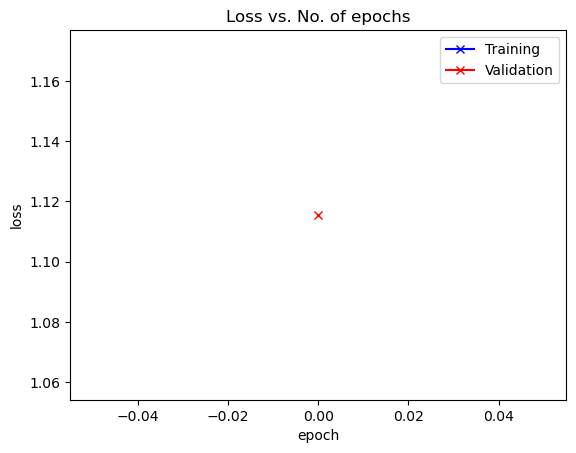

In [16]:
plot_losses(history)

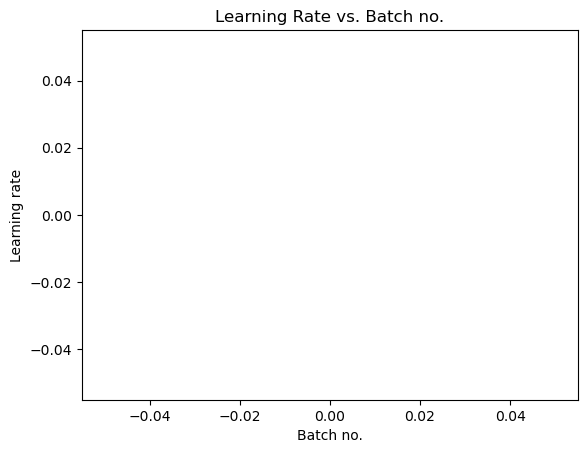

In [17]:
plot_lrs(history)

In [ ]:
# torch.save(model, 'saved_models/model_attention_pre_1.pt')

In [3]:
import cv2
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
from models.vision import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = ResNetWithAttention().to(device)
# Load the saved model
loaded_model = torch.load('saved_models/model_attention_pre_1.pt')

loaded_model = loaded_model.to(device)
loaded_model.eval()

# Define the transformations to be applied to each frame
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5079, 0.5079, 0.5079],
                         std=[0.2563, 0.2563, 0.2563])
])

# Open the webcam
cap = cv2.VideoCapture(0)
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Load the face detection model
face_cascade = cv2.CascadeClassifier('saved_models/haarcascade_frontalface_default.xml')

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        # Crop the face from the frame
        face = frame[y:y+h, x:x+w]

        # Convert the face to a PIL image
        pil_image = Image.fromarray(face)
        
        pil_image = pil_image.convert('L')
        # Convert the image to a numpy array
        np_image = np.array(pil_image)
        # Create a 3-channel image by repeating the grayscale values
        np_image = np.repeat(np_image[:, :, np.newaxis], 3, axis=2)
        # Convert the numpy array back to a PIL image
        pil_image = Image.fromarray(np_image)

        # Apply the transformations to the PIL image
        tensor_image = transform(pil_image)

        # Add a batch dimension to the tensor image
        tensor_image = tensor_image.unsqueeze(0)

        # Move the tensor image to the device
        tensor_image = tensor_image.to(device)
        
        # Make a prediction on the tensor image
        with torch.no_grad():
            output = loaded_model(tensor_image)
            _, predicted = torch.max(output, 1)
            predicted_class = predicted.item()

        # Display the predicted class on the frame
        cv2.putText(frame, str(classes[predicted_class]), (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

        # Draw a rectangle around the face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Display the resulting frame
    cv2.imshow('frame', frame)

    # Exit the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the capture and destroy the window
cap.release()
cv2.destroyAllWindows()


e:\Users\abuba\anaconda3\envs\dl\envs\dl_cuda\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
e:\Users\abuba\anaconda3\envs\dl\envs\dl_cuda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
